In [2]:
import numpy as np
import pandas as pd
from numba import njit, prange
from tqdm import tqdm
import matplotlib.pyplot as plt

In [3]:
df0 = pd.read_csv('../data/btcusdt/2025102617_tradebars.csv').dropna()
df1 = pd.read_csv('../data/btcusdt/2025102820_tradebars.csv').dropna()
df2 = pd.read_csv('../data/btcusdt/2025102821_tradebars.csv').dropna()
df3 = pd.read_csv('../data/btcusdt/2025102822_tradebars.csv').dropna()

df = pd.concat([df0, df1, df2, df3], ignore_index=True)
df = df.sort_values('timestamp').reset_index(drop=True)

In [4]:
df.tail()

,timestamp,open,high,low,close,volume
14557,2025-10-28 16:32:59.615,115166.48,115166.49,115166.48,115166.49,0.05002
14558,2025-10-28 16:33:00.315,115166.49,115173.73,115166.49,115173.73,0.07389
14559,2025-10-28 16:33:00.495,115173.73,115181.41,115173.73,115181.41,0.06825
14560,2025-10-28 16:33:01.150,115181.41,115196.39,115181.41,115196.39,0.09011
14561,2025-10-28 16:33:01.315,115196.39,115199.11,115196.39,115199.11,0.06238


In [5]:
# log return 
df['ret'] = np.log(df['close'] / df['close'].shift(1))

window = 4
df['rw_mean'] = df['ret'].rolling(window).mean().shift(1)
df['rw_std'] = df['ret'].rolling(window).std().shift(1)
df['rw_std'] = df['rw_std'].replace(0, 1e-8)

# Z-score (using only past info)
df['zscore'] = (df['ret'] - df['rw_mean']) / df['rw_std'] + 1e-8

# EMAs (momentum)
df['ema_fast'] = df['close'].ewm(span=window, adjust=False).mean().shift(1)
df['ema_slow'] = df['close'].ewm(span=window*3, adjust=False).mean().shift(1)
df['mom'] = df['ema_fast'] - df['ema_slow']

# directional sign feature
df['ret_sign'] = np.sign(df['ret']).shift(1)
df['ret_sign_sum'] = df['ret_sign'].rolling(window).sum().shift(1)

# lagged returns
for lag in range(1, 4):
    df[f'ret_lag{lag}'] = df['ret'].shift(lag)

df = df.dropna().reset_index(drop=True)

In [6]:
df.tail()

,timestamp,open,high,low,close,volume,ret,rw_mean,rw_std,zscore,ema_fast,ema_slow,mom,ret_sign,ret_sign_sum,ret_lag1,ret_lag2,ret_lag3
14551,2025-10-28 16:32:59.615,115166.48,115166.49,115166.48,115166.49,0.05002,8.683082e-08,-0.000021,0.000041,0.502101,115171.223471,115181.213806,-9.990335,0.0,-2.0,0.000000e+00,-8.265953e-05,0.000000e+00
14552,2025-10-28 16:33:00.315,115166.49,115173.73,115166.49,115173.73,0.07389,6.286353e-05,-0.000021,0.000041,2.019790,115169.330083,115178.948605,-9.618522,1.0,-1.0,8.683082e-08,0.000000e+00,-8.265953e-05
14553,2025-10-28 16:33:00.495,115173.73,115181.41,115173.73,115181.41,0.06825,6.667965e-05,-0.000005,0.000060,1.199724,115171.090050,115178.145743,-7.055693,1.0,0.0,6.286353e-05,8.683082e-08,0.000000e+00
14554,2025-10-28 16:33:01.150,115181.41,115196.39,115181.41,115196.39,0.09011,1.300473e-04,0.000032,0.000037,2.610458,115175.218030,115178.647936,-3.429906,1.0,1.0,6.667965e-05,6.286353e-05,8.683082e-08
14555,2025-10-28 16:33:01.315,115196.39,115199.11,115196.39,115199.11,0.06238,2.361157e-05,0.000065,0.000053,-0.778228,115183.686818,115181.377485,2.309333,1.0,3.0,1.300473e-04,6.667965e-05,6.286353e-05


In [7]:
def getEvents(gRaw, h):
    tEvents, sPos, sNeg = [], 0.0, 0.0
    diff = gRaw.diff()
    for i in diff.index[1:]:
        sPos, sNeg = max(0, sPos+diff.loc[i]), min(0, sNeg+diff.loc[i])
        if sPos > h: sPos = 0; tEvents.append(i)
        elif sNeg < -h: sNeg = 0; tEvents.append(i)
    return tEvents

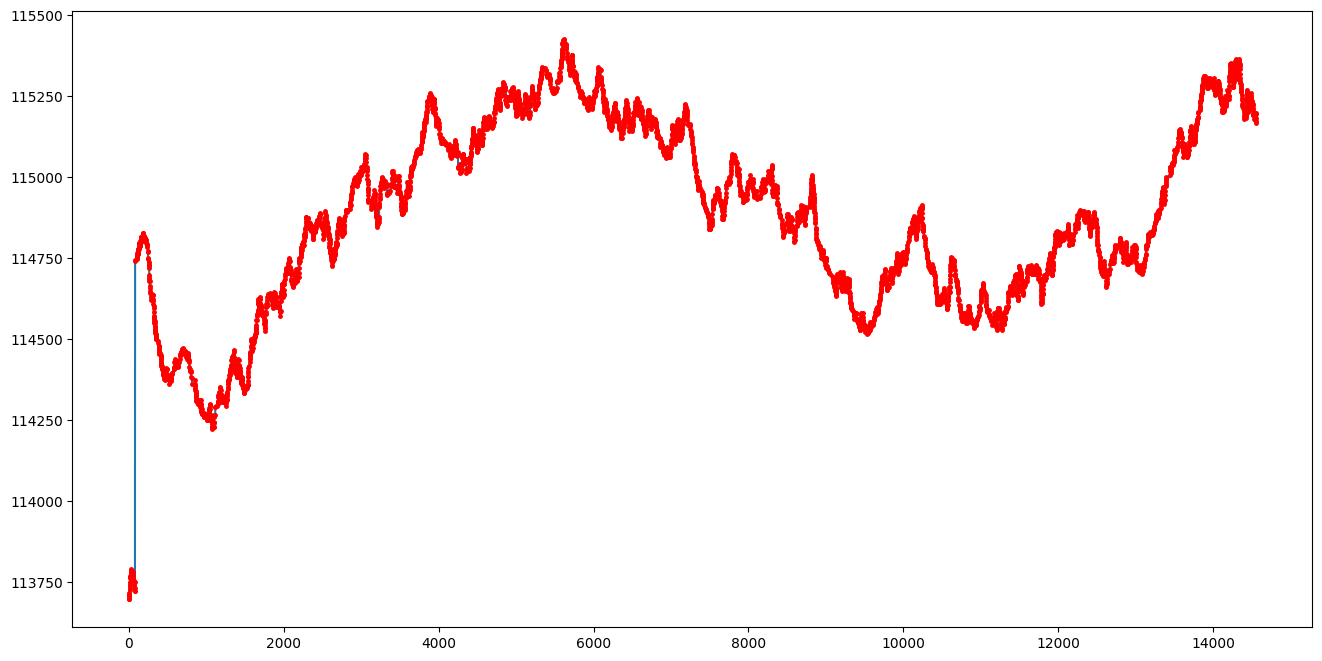

In [8]:
Events = getEvents(df['close'], 1)
plt.figure(figsize=(16,8))
plt.plot(df['close'])
plt.plot(df['close'][Events], 'ro', markersize=2.5);

In [9]:
Events.__len__()

5150

In [10]:
def triple_barrier_method(close, events, ptSl, molecule):
    events_ = events.loc[molecule]
    out = events_[['t1']].copy(deep=True)

    # Profit-taking and stop-loss barriers
    if ptSl[0] > 0:pt = ptSl[0] * events_['trgt']
    else: pt = pd.Series(index=events_.index, dtype=float)

    if ptSl[1] > 0:sl = -ptSl[1] * events_['trgt']
    else: sl = pd.Series(index=events_.index, dtype=float)

    for loc, t1 in zip(events_.index, events_['t1'].fillna(close.index[-1])):
        df0 = close.loc[loc:t1]  # path prices
        df0 = (df0 / close.loc[loc] - 1) * events_.at[loc, 'side']

        out.at[loc, 'sl'] = df0[df0 < sl[loc]].index.min()  
        out.at[loc, 'pt'] = df0[df0 > pt[loc]].index.min()  
    return out

In [11]:
def get_events(prices, tEvents, pt_sl, trgt, min_ret, t1=False):
    "Create events dataframe for triple-barrier method."
    trgt = trgt.loc[tEvents]
    trgt = trgt[trgt > min_ret]

    if t1 is False: t1=pd.Series(pd.NaT, index=tEvents)

    side_ = pd.Series(1., index=trgt.index)
    events = pd.concat({'t1': t1, 'trgt': trgt, 'side': side_}, axis=1).dropna(subset=['trgt'])
    df0 = triple_barrier_method(prices, events, pt_sl, events.index)
    events['t1'] = df0.dropna(how='all').min(axis=1)
    events = events.drop('side', axis=1)
    return events, df0

In [17]:
# Generate vertical barrier timestamps (every h bars)
h, n = 60, len(df)
t1 = pd.Series([i + h if i + h < n else n-1 for i in range(n)], name='t1')
t1

0           60
1           61
2           62
3           63
4           64
         ...  
14551    14555
14552    14555
14553    14555
14554    14555
14555    14555
Name: t1, Length: 14556, dtype: int64

In [18]:
t1 = pd.Series([min(i + 60, n - 1) for i in range(n)], name="t1")
t1

0           60
1           61
2           62
3           63
4           64
         ...  
14551    14555
14552    14555
14553    14555
14554    14555
14555    14555
Name: t1, Length: 14556, dtype: int64

In [19]:
Labels, dFrame = get_events(df['close'], Events, [1, 1], df['close'].pct_change().abs(), 0.0, t1)
Labels

,t1,trgt
1,3.0,0.000027
3,4.0,0.000032
4,8.0,0.000105
5,6.0,0.000021
6,7.0,0.000045
...,...,...
14549,14553.0,0.000083
14552,14553.0,0.000063
14553,14554.0,0.000067
14554,14555.0,0.000130


In [20]:
dFrame.head()

,t1,sl,pt
1,61,4.0,3.0
3,63,4.0,8.0
4,64,NaN,8.0
5,65,NaN,6.0
6,66,NaN,7.0


In [21]:
def getBins(events, prices):
    events_ = events.dropna(subset=['t1'])
    px = events_.index.union(events_['t1'].values).drop_duplicates()
    px = prices.reindex(px, method="bfill")
    out = pd.DataFrame(index=events_.index)
    out['ret'] = px.loc[events_['t1'].values].values / px.loc[events_.index]-1
    out['bin'] = np.sign(out['ret'])
    return out

In [22]:
bins = getBins(Labels, df['close'])

In [23]:
bins

,ret,bin
1,0.000032,1.0
3,-0.000105,-1.0
4,0.000161,1.0
5,0.000045,1.0
6,0.000081,1.0
...,...,...
14549,0.000130,1.0
14552,0.000067,1.0
14553,0.000130,1.0
14554,0.000024,1.0


In [ ]:
def get_events(prices, tEvents, pt_sl, trgt, min_ret, t1=False, side=None):
    "Create events dataframe for triple-barrier method."
    trgt = trgt.loc[tEvents]
    trgt = trgt[trgt > min_ret]

    if t1 is False: t1=pd.Series(pd.NaT, index=tEvents)

    if side is None:side_,pt_sl_ = pd.Series(1., index=trgt.index), [pt_sl[0], pt_sl[0]]
    else:side_, pt_sl_ = side.loc[trgt.index], pt_sl[:2]
    events = pd.concat({'t1': t1, 'trgt': trgt, 'side': side_}, axis=1).dropna(subset=['trgt'])
    df0 = triple_barrier_method(prices, events, pt_sl_, events.index)
    events['t1'] = df0.dropna(how='all').min(axis=1)
    if side is None: events = events.drop('side', axis=1)
    return events, df0

In [ ]:
Labels01, dFrame01 = get_events(df['close'], Events, [1, 1], df['close'].pct_change().abs(), 0.0, t1=t1)

In [ ]:
dFrame01

In [ ]:
def getBins(events, prices):
    events_ = events.dropna(subset=['t1'])
    px = events_.index.union(events_['t1'].values).drop_duplicates()
    px = prices.reindex(px, method='bfill')
    out = pd.DataFrame(index=events_.index)
    out['ret'] = px.loc[events_['t1'].values].values / px.loc[events_.index]-1
    if 'side' in events_: out['ret'] *= events_['side']
    out['bin'] = np.sign(out['ret'])
    if 'side' in events_: out.loc[out['ret'] <= 0, 'bin'] = 0
    return out

In [ ]:
bins01 = getBins(Labels01, df['close'])

In [ ]:
bins01

In [ ]:
def mpNumCoEvents(closeIdx, t1, molecule):
    """
    Compute the number of concurrent events per bar.
    + molecule[0] is the date of the first event on which the weight will be computed
    + molecule[-1] is the date of the last event on which the weight will be computed 
    Any event that starts before t1[molecule].max() impacts the count.
    """
    # 1) find events that span the period [molecule[0], molecule[-1]]
    t1 = t1.fillna(closeIdx[-1])                 # unclosed events still must impact other weights
    t1 = t1[t1 >= molecule[0]]                   # events that end at or after molecule[0]
    t1 = t1.loc[:t1[molecule].max()]             # events that start at or before t1[molecule].max()

    # 2) count events spanning a bar
    iloc = closeIdx.searchsorted(np.array([t1.index[0], t1.max()]))
    count = pd.Series(0, index=closeIdx[iloc[0]:iloc[1] + 1])
    for tIn in t1.index.tolist():
        tOut = t1.loc[tIn]
        count.loc[tIn:tOut] += 1.0

    return count.loc[molecule[0]:t1[molecule].max()]

In [ ]:
closeIdx = df.index
t1 = pd.Series(Labels01['t1'],index=Events, dtype='float64')

In [ ]:
t1

In [ ]:
count = mpNumCoEvents(closeIdx, t1, Events)
count

In [ ]:
def mpSampleTW(t1, numCoEvents, molecule):
    # Derive average uniqueness over the event's lifespan
    wght = pd.Series(index=molecule)
    for tIn in molecule:
        tOut = t1.loc[tIn] 
        wght.loc[tIn] = (1.0 / numCoEvents.loc[tIn:tOut]).mean()
    return wght

In [ ]:
wght = mpSampleTW(t1, count, Events)

In [ ]:
wght

In [ ]:
def getIndMatrix(barIx, t1):
    # get indication matrix
    indM = pd.DataFrame(0, index=barIx, columns=range(t1.shape[0]))
    for i, tIn in enumerate(t1.index):
        tOut = t1.loc[tIn]
        indM.loc[tIn:tOut, i] = 1
    return indM

In [ ]:
indM = getIndMatrix(closeIdx, t1)

In [ ]:
indM

In [ ]:
def getAvgUniq(indM):
    # Average Uniqueness from Indication Matrix
    c = indM.sum(axis=1) # concurrency
    u = indM.div(c, axis=0) # uniqueness
    avgU = u[u>0].mean() # average uniqueness
    return avgU

In [ ]:
avgU = getAvgUniq(indM)
avgU

In [ ]:
def seqBootstrap(indM, sLength=None):
    # generate a sample via sequential bootstrap
    if sLength is None: sLength=indM.shape[1]
    phi = []
    while len(phi) < sLength:
        avgU = pd.Series()
        for i in indM:
            indM_ = indM[phi+[i]]
            avgU.loc[i] = getAvgUniq(indM_).iloc[-1]
        prob = avgU / avgU.sum() # draw prob
        phi += [np.random.choice(indM.columns, p=prob).item()]
    return phi

In [ ]:
indM.columns, indM.shape[1]

In [ ]:
from tqdm import tqdm
import numpy as np

def fast_seqBootstrap(indM, sLength=None):
    indM = indM.values.astype(np.float32)
    n_obs, n_events = indM.shape
    if sLength is None:
        sLength = n_events
    
    phi = []
    mask = np.zeros(n_events, dtype=bool)
    concurrency = indM.sum(axis=1)
    
    # tqdm progress bar
    for _ in tqdm(range(sLength), desc="Sequential Bootstrap Progress", ncols=80):
        avgU = np.zeros(n_events, dtype=np.float32)
        
        # compute uniqueness for unselected events
        for i in np.where(~mask)[0]:
            temp_mask = mask.copy()
            temp_mask[i] = True
            temp_uniqueness = indM[:, temp_mask] / np.maximum(concurrency[:, None], 1)
            avgU[i] = np.mean(temp_uniqueness[temp_uniqueness > 0])
        
        prob = avgU / avgU.sum()
        chosen = np.random.choice(np.arange(n_events), p=prob)
        phi.append(chosen)
        mask[chosen] = True
    
    return phi

In [ ]:
@njit
def weighted_random_choice(prob):
    """
    Equivalent to np.random.choice with p=prob (Numba compatible).
    """
    r = np.random.random()
    cum = 0.0
    for i in range(prob.shape[0]):
        cum += prob[i]
        if r < cum:
            return i
    return prob.shape[0] - 1


@njit(parallel=True)
def _seqBootstrap_step(indM, concurrency, mask):
    n_obs, n_events = indM.shape
    avgU = np.zeros(n_events, np.float32)
    total = np.float32(0.0)

    for i in prange(n_events):
        if mask[i] == 0:
            val = np.float32(0.0)
            count = 0
            for j in range(n_obs):
                if indM[j, i] > 0:
                    val += indM[j, i] / max(concurrency[j], 1)
                    count += 1
            if count > 0:
                avgU[i] = val / count
                total += avgU[i]

    if total == 0:
        prob = np.ones(n_events, np.float32) / n_events
    else:
        prob = avgU / total

    chosen = weighted_random_choice(prob)
    return chosen



def seqBootstrap_numba_tqdm(indM, sLength=None):
    if isinstance(indM, pd.DataFrame):
        indM = indM.values.astype(np.float32)
    else:
        indM = indM.astype(np.float32)

    n_obs, n_events = indM.shape
    if sLength is None:
        sLength = n_events

    concurrency = indM.sum(axis=1).astype(np.float32)
    mask = np.zeros(n_events, np.int32)
    phi = np.zeros(sLength, np.int32)

    for step in tqdm(range(sLength), desc="Sequential Bootstrapping"):
        chosen = _seqBootstrap_step(indM, concurrency, mask)
        phi[step] = chosen
        mask[chosen] = 1

    return phi


In [ ]:
def main():
    indM=getIndMatrix(closeIdx,t1)
    phi=np.random.choice(indM.columns,size=indM.shape[1])
    print(phi)
    print('Standard uniqueness:',getAvgUniq(indM[phi]).mean())
    phi=seqBootstrap_numba_tqdm(indM)
    print(phi)
    print('Sequential uniqueness:',getAvgUniq(indM[phi]).mean())
    return

In [ ]:
main()

In [ ]:
def mpSampleW(t1, numCoEvents, close, molecule):
    # Derive sample weights by return attribution
    ret=np.log(close).diff()
    wght=pd.Series(index=molecule)
    for tIn in molecule:
        tOut=t1.loc[tIn]
        wght.loc[tIn]=(ret.loc[tIn:tOut]/numCoEvents.loc[tIn:tOut]).sum()
    return wght.abs()

In [ ]:
wght01 = mpSampleW(t1, count, df['close'], Events)

In [ ]:
wght01

In [ ]:
def getTimeDecay(tW, clfLastW=1):
    # apply piecewise linear time decay to observerd uniqueness (tW)
    # newest observations get weight = 1, oldest pbservation get weight = clfLastW
    clfW = tW.sort_index().cumsum()
    if clfLastW>=0: slope=(1.-clfLastW)/clfW.iloc[-1]
    else: slope=1./ ((clfLastW+1)*clfW.iloc[-1])
    const=1.-slope*clfW.iloc[-1]
    clfW=const + slope*clfW
    clfW[clfW<0]=0
    print(const, slope)
    return clfW

In [ ]:
clfW = getTimeDecay(wght01, clfLastW=0.5)

In [ ]:
clfW

In [ ]:
def getWeights_FFD(d, thres):
    # thres>0 drops insignificant weights
    w = [1.0]
    k = 1
    while True:
        w_ = -w[-1] /k* (d - k + 1) 
        if abs(w_) < thres:
            break
        w.append(w_)
        k += 1
    w = np.array(w[::-1]).reshape(-1, 1)
    return w

In [ ]:
wghts = getWeights_FFD(d=0.4, thres=1e-5)
wghts


In [ ]:
def fracDiff_FFD(series,d,thres=1e-5):
    '''
    Constant width window (new solution)
    Note 1: thres determines the cut-off weight for the window
    Note 2: d can be any positive fractional, not necessarily bounded [0,1].
    '''
    #1) Compute weights for the longest series
    w=getWeights_FFD(d, thres)
    width=len(w)-1
    #2) Apply weights to values
    df={}
    for name in series.columns:
        seriesF,df_=series[[name]].fillna(method='ffill').dropna(),pd.Series()
        for iloc1 in range(width,seriesF.shape[0]):
            loc0,loc1=seriesF.index[iloc1-width],seriesF.index[iloc1]
            if not np.isfinite(series.loc[loc1,name]):continue # exclude NAs
            df_[loc1]=np.dot(w.T,seriesF.loc[loc0:loc1])[0,0]
        df[name]=df_.copy(deep=True)
    df=pd.concat(df,axis=1)
    return df

In [ ]:
df_ = fracDiff_FFD(df[['close', 'ema_fast', 'ema_slow']], d=0.6, thres=0.04)

In [ ]:
df_

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier()

In [ ]:
df  = df.drop(df.columns[:4], axis=1)
df['close'] = df_['close']
df['ema_fast'] = df_['ema_fast']
df['ema_slow'] = df_['ema_slow']
df = df.dropna()
df.head()

In [ ]:
X = df
y = bins01['bin'].loc[clfW.index[1:]].dropna()

In [ ]:
idx = seqBootstrap_numba_tqdm(indM, sLength=2000)

In [ ]:
def gSamples(idx, events, removal):
    idx = [events[i] for i in idx if i not in removal]
    return idx

In [ ]:
samples = gSamples(idx, Events, [0, 1, 2])

In [ ]:
dset = df.loc[samples].sort_index().drop_duplicates()

In [ ]:
dset

In [ ]:
from sklearn.model_selection import train_test_split
X, y = dset.values, y.loc[dset.index]
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=False)
sample_wghts = clfW.loc[y.index][:len(ytrain)]
sample_wghts

In [ ]:
sample_wghts_test = clfW.loc[y.index][len(ytrain):]

In [ ]:
sample_wghts_test

In [ ]:
xtrain.shape

In [ ]:
xtrain, ytrain.values

In [ ]:
clf.fit(xtrain, ytrain.values, sample_weight=sample_wghts)

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
accuracy_score(ytest, clf.predict(xtest), sample_weight=sample_wghts_test)

In [ ]:
y.value_counts()

In [ ]:
from sklearn.model_selection._split import _BaseKFold


class PurgedKFold(_BaseKFold):
    """
    Extend KFold to work with labels that span time intervals.
    The training set is purged of observations that overlap with the test-label intervals.
    The test set is assumed contiguous (shuffle=False), without training samples in between.
    """

    def __init__(self, n_splits=3, t1=None, pctEmbargo=0.):
        if not isinstance(t1, pd.Series):
            raise ValueError("Label Through Dates (t1) must be a pandas Series.")
        super().__init__(n_splits=n_splits, shuffle=False, random_state=None)
        self.t1 = t1
        self.pctEmbargo = pctEmbargo

    def split(self, X, y=None, groups=None):
        if (X.index == self.t1.index).sum() != len(self.t1):
            raise ValueError("X and t1 must have the same index")

        indices = np.arange(X.shape[0])
        mbrg = int(X.shape[0] * self.pctEmbargo)
        test_ranges = [(idx[0], idx[-1] + 1) for idx in np.array_split(indices, self.n_splits)]

        for i, j in test_ranges:
            t0 = self.t1.index[i]  # start of test set
            test_indices = indices[i:j]
            maxT1Idx = self.t1.index.searchsorted(self.t1.iloc[test_indices].max())

            train_indices = self.t1.index.searchsorted(self.t1[self.t1 <= t0].index)

            if maxT1Idx < X.shape[0]:  # right train (with embargo)
                train_indices = np.concatenate((train_indices, indices[maxT1Idx + mbrg:]))

            yield train_indices, test_indices


In [ ]:
def cvScore(clf,X,y,sample_weight,scoring='neg_log_loss',t1=None,cv=None,cvGen=None,
    pctEmbargo=None):
    if scoring not in ['neg_log_loss','accuracy']:
        raise Exception('wrong scoring method.')
    from sklearn.metrics import log_loss,accuracy_score
    if cvGen is None:
        cvGen=PurgedKFold(n_splits=cv,t1=t1,pctEmbargo=pctEmbargo) # purged
    score=[]
    for train,test in cvGen.split(X=X):
        fit=clf.fit(X=X.iloc[train,:],y=y.iloc[train],
            sample_weight=sample_weight.iloc[train].values)
    if scoring=='neg_log_loss':
        prob=fit.predict_proba(X.iloc[test,:])
        score_=-log_loss(y.iloc[test],prob,
            sample_weight=sample_weight.iloc[test].values,labels=clf.classes_)
    else:
        pred=fit.predict(X.iloc[test,:])
        score_=accuracy_score(y.iloc[test],pred,sample_weight= \
                sample_weight.iloc[test].values)
    score.append(score_)
    return np.array(score)

In [ ]:
X, y = dset, y.loc[dset.index]

In [ ]:
t1 = t1.loc[X.index]

In [ ]:
sample_wghts = clfW.loc[dset.index]

In [ ]:
cvScore(clf, X, y, sample_wghts, scoring='accuracy', t1=t1, cv=3, pctEmbargo=0.01)

In [ ]:
def featImpMDA(clf,X,y,cv,sample_weight,t1,pctEmbargo,scoring='neg_log_loss'):
    # feat importance based on OOS score reduction
    if scoring not in ['neg_log_loss','accuracy']:
        raise Exception('wrong scoring method.')
    from sklearn.metrics import log_loss,accuracy_score
    cvGen=PurgedKFold(n_splits=cv,t1=t1,pctEmbargo=pctEmbargo) # purged cv
    scr0,scr1=pd.Series(),pd.DataFrame(columns=X.columns)
    for i,(train,test) in enumerate(cvGen.split(X=X)):
        X0,y0,w0=X.iloc[train,:],y.iloc[train],sample_weight.iloc[train]
        X1,y1,w1=X.iloc[test,:],y.iloc[test],sample_weight.iloc[test]
        fit=clf.fit(X=X0,y=y0,sample_weight=w0.values)
    if scoring=='neg_log_loss':
        prob=fit.predict_proba(X1)
        scr0.loc[i]=-log_loss(y1,prob,sample_weight=w1.values,
        labels=clf.classes_)
    else:
        pred=fit.predict(X1)
        scr0.loc[i]=accuracy_score(y1,pred,sample_weight=w1.values)
    for j in X.columns:
        X1_=X1.copy(deep=True)
        np.random.shuffle(X1_[j].values) # permutation of a single column
        if scoring=='neg_log_loss':
            prob=fit.predict_proba(X1_)
            scr1.loc[i,j]=-log_loss(y1,prob,sample_weight=w1.values,
            labels=clf.classes_)
        else:
            pred=fit.predict(X1_)
            scr1.loc[i,j]=accuracy_score(y1,pred,sample_weight=w1.values)
    imp=(-scr1).add(scr0,axis=0)
    if scoring=='neg_log_loss':imp=imp/-scr1
    else:imp=imp/(1.-scr1)
    imp=pd.concat({'mean':imp.mean(),'std':imp.std()*imp.shape[0]**-.5},axis=1)
    return imp,scr0.mean()

In [ ]:
imp, scr = featImpMDA(clf, X, y, cv=5, t1=t1, pctEmbargo=0.01, scoring='accuracy', sample_weight=sample_wghts)

In [ ]:
imp, scr

In [ ]:
imp = imp.sort_values(by=('mean'), ascending=False)
imp['mean'].plot(kind='bar', figsize=(10,4), title='MDA Feature Importance');

In [ ]:
clf.feature_importances_

In [ ]:
df.columns

In [ ]:
for col, imp in zip(df.columns, clf.feature_importances_):
    print(f"{col}: {imp}")

In [ ]:
sns.heatmap(X.corr(), cmap='coolwarm', center=0)